<a href="https://colab.research.google.com/github/Cleps/PavicNet-MC/blob/main/multilabel_PavicNet_MC_Github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import suppporting libraries
import tarfile
import urllib.request as urllib2
import os
import cv2
from os import listdir
from os.path import isfile, join
import re
#Import deep learning libraries
import cv2
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tqdm as tqdm
import tensorflow_hub as hub

#Import data analytics libraries
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import scipy.io
import pandas as pd
import seaborn as sns
#Import image visualization libraries
from PIL import *
from PIL import ImageFile
from PIL import Image
#System settings
ImageFile.LOAD_TRUNCATED_IMAGES = True
os.environ['WANDB_CONSOLE'] = 'off'
#Coloring for print outputs
class color:
   RED = '\033[91m'
   BOLD = '\033[1m'
   END = '\033[0m'

In [2]:
!nvidia-smi

Wed May  3 19:54:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
!cp  /content/drive/MyDrive/datasets/convex.zip /content/

In [5]:
!cp /content/drive/MyDrive/datasets/dataset_metadata.csv /content/

In [6]:
!unzip -q convex.zip -d /content/temp

In [7]:
path='/content/temp/convex'
annotation_path = "dataset_metadata.csv"
videos_list = os.listdir(path)

In [8]:
columns = ['Filename', 'Effusion', 'Consolidations', 'B-lines', 'A-lines', 'Pleural_line_irregularities', 'Air_bronchogram', 'Label']
base = pd.read_csv(annotation_path, usecols=columns)

In [9]:
base = base[base['Effusion'] != 'n/A']
base = base[base['Consolidations'] != 'n/A']
base = base[base['B-lines'] != 'n/A']
base = base[base['A-lines']  != 'n/A']
base = base[base['Pleural_line_irregularities']  != 'n/A']
base = base[base['Air_bronchogram']  != 'n/A']
base = base[base['Label']  != 'n/A']
#base = base[base['Label']  != 'regular']
#base = base[base['Label']  != 'Regular']
base['Label']= base['Label'].replace(['regular'], 'Regular')

base['Effusion'] = pd.to_numeric(base['Effusion'])
base.head()

,Filename,Label,Effusion,Consolidations,B-lines,A-lines,Pleural_line_irregularities,Air_bronchogram
0,Cov-Butterfly-COVID Lung 2,COVID-19,1.0,0.0,1.0,0.0,1.0,0.0
1,Cov-Butterfly-Skip Lesion,COVID-19,0.0,1.0,1.0,1.0,1.0,0.0
2,Cov-Butterfly-Confluent B lines,COVID-19,0.0,0.0,1.0,0.0,0.0,0.0
3,Reg-Butterfly-Normal Lung A lines,Regular,0.0,0.0,0.0,1.0,0.0,0.0
4,Reg-Butterfly-Normal Lung_Example 2,Regular,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
base  = base.dropna(axis = 0)
base.shape

(346, 8)

In [11]:
metadata = base;
metadata['Filename']

0               Cov-Butterfly-COVID Lung 2
1                Cov-Butterfly-Skip Lesion
2          Cov-Butterfly-Confluent B lines
3        Reg-Butterfly-Normal Lung A lines
4      Reg-Butterfly-Normal Lung_Example 2
                      ...                 
344                Cov-B_ConvexProb_score1
345               Cov-C_Convex_Prob_score2
346               Cov-D_Convex_Prob_score3
347                Cov-C_ConvexProb_score3
348                    Cov-MSU-SkipLesions
Name: Filename, Length: 346, dtype: object

In [12]:
effusion_list = []
consolid_list = []
aline_list = []
bline_list = []
pli_list = []
airb_list = []
filenames = []
y_labels = []
num_imgs_per_video = 20
path_imgs_train = '/content/drive/MyDrive/datasets/imgs'
#os.mkdir(path_imgs_train)
os.mkdir("/content/dataset")

In [13]:
# DATA SETINGS

IMG_SIZE = 224 # Specify height and width of image to match the input format of the model
CHANNELS = 1 # Keep RGB color channels to match the input format of the model
num_imgs_per_video=20

In [14]:
def create_mydataset_all_gray():
    X_train, y_train = [], []
    for filename in videos_list:
        count=0
        #print(filename)
        vid_cap = cv2.VideoCapture(path+'/'+filename)
        total_frame_count= int(vid_cap.get(cv2.CAP_PROP_FRAME_COUNT))
        step = total_frame_count/num_imgs_per_video
        success, image = vid_cap.read()
        metadata_cap = metadata.loc[metadata.Filename == filename.split('.')[0]]
        if len(metadata_cap) >0:
            while success:
                #print("Reading new frame...", success)
                if ((count+1) % int(step) == 0):
                    #print("Writing new frame...")
                    out = '/content/dataset/{}_{}.png'.format(filename.split('.')[0], count)
                    cv2.imwrite(out,cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))
                    img = tf.keras.utils.load_img(out, target_size = (224, 224, 1),color_mode="grayscale")
                    img = tf.keras.utils.img_to_array(img)
                    img= img/255.
                    #img = img.transpose(2,0,1)
                    X_train.append(img)
                    y_train.append([metadata['A-lines'][metadata_cap.index[0]],
                                    metadata['B-lines'][metadata_cap.index[0]],
                                    metadata['Effusion'][metadata_cap.index[0]],
                                    metadata['Consolidations'][metadata_cap.index[0]],
                                    metadata['Pleural_line_irregularities'][metadata_cap.index[0]]])
                                     #metadata['Air_bronchogram'][metadata_cap.index[0]]])
                success, image = vid_cap.read()
                count += 1
    X = np.array(X_train)
    y = np.array(y_train)
    return X, y

In [15]:
# create dataset!!
X, y = create_mydataset_all_gray()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=20, test_size=0.2, shuffle=True)
X_train.shape, y_train.shape
del X
del y

In [16]:
X_train.shape

(2668, 224, 224, 1)

In [17]:
# PAVICNET-MC ORIGINAL CODE

def residual_block(inputs):
  residual = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1)(inputs)
  residual = tf.keras.layers.BatchNormalization()(residual)
  residual = tf.keras.layers.ReLU()(residual)
  #residual = tf.keras.layers.MaxPool2D(4)(residual)
  residual = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1)(residual)
  residual = tf.keras.layers.BatchNormalization()(residual)
  residual = tf.keras.layers.ReLU()(residual)
  #residual = tf.keras.layers.MaxPool2D(4)(residual)

  residual = tf.keras.layers.Flatten()(residual) #
  #residual = tf.keras.layers.Dense(128, activation='relu')(residual)
  residual = tf.keras.layers.Dense(64, activation='relu')(residual)
  residual = tf.keras.layers.Dense(32, activation='relu')(residual)
  return residual

def Model_3():
  inputs = tf.keras.layers.Input(shape=(224, 224, 1))
  x = tf.keras.layers.Conv2D(filters=8, kernel_size=3, strides=1)(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(4)(x)

  x = tf.keras.layers.Conv2D(filters=16, kernel_size=3, strides=1)(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  x = tf.keras.layers.MaxPool2D(4)(x)

  residual = residual_block(x)
  #residual = residual_block(residual)

  #x = tf.keras.layers.Flatten()(residual)
  x = tf.keras.layers.Dense(16, activation='relu')(residual)
  x = tf.keras.layers.Dense(8, activation='relu')(x)
  x = tf.keras.layers.Dense(5, activation='sigmoid')(x)

  #x = tf.keras.layers.add([x, residual]) #
  model = tf.keras.Model(inputs=inputs, outputs=x)

  return model


In [18]:
model01 = Model_3()
model01.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 8)       80        
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 8)      32        
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 222, 222, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 16)        1168  

In [19]:
# COMPILE MODEL
model01.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [20]:
#fit the model
history_1 = model01.fit(X_train, y_train,
                        epochs=100,
                        validation_data=(X_test, y_test))

Epoch 1/100
84/84 [==============================] - 17s 28ms/step - loss: 0.6045 - accuracy: 0.1645 - val_loss: 0.5798 - val_accuracy: 0.0570
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3753 - accuracy: 0.2897 - val_loss: 0.4884 - val_accuracy: 0.2144
Epoch 3/100
84/84 [==============================] - 2s 18ms/step - loss: 0.2913 - accuracy: 0.3617 - val_loss: 0.4672 - val_accuracy: 0.2024
Epoch 4/100
84/84 [==============================] - 2s 19ms/step - loss: 0.2489 - accuracy: 0.4007 - val_loss: 0.4287 - val_accuracy: 0.2384
Epoch 5/100
84/84 [==============================] - 2s 23ms/step - loss: 0.2187 - accuracy: 0.4115 - val_loss: 0.3298 - val_accuracy: 0.2489
Epoch 6/100
84/84 [==============================] - 2s 22ms/step - loss: 0.1934 - accuracy: 0.4397 - val_loss: 0.2404 - val_accuracy: 0.3178
Epoch 7/100
84/84 [==============================] - 2s 19ms/step - loss: 0.1695 - accuracy: 0.4558 - val_loss: 0.1844 - val_accuracy: 0.4138
Epoch

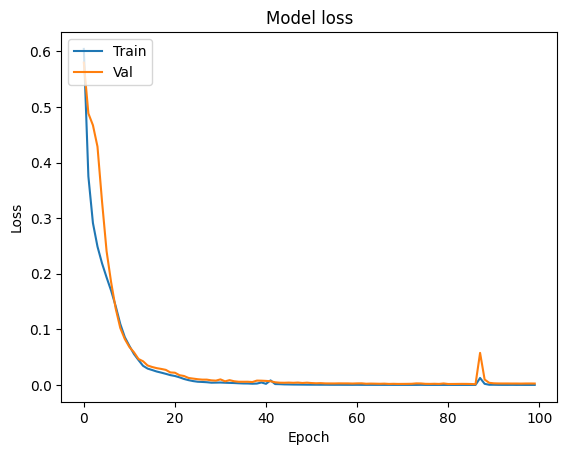

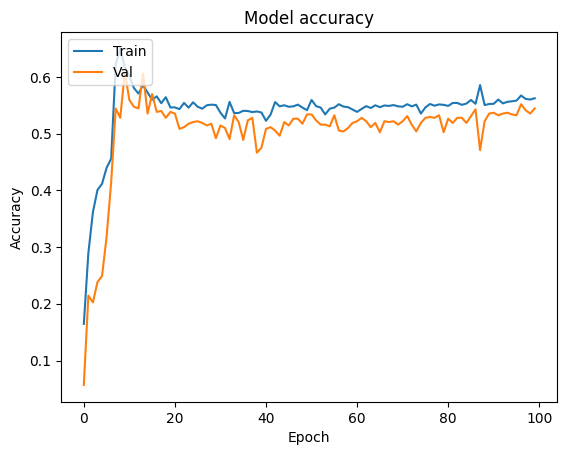

In [21]:
#Loss and acc

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [22]:
## plot results


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

def plot_results(y_test, preds):
  effusion_list_preds = []
  consolid_list_preds = []
  aline_list_preds = []
  bline_list_preds = []
  pli_list_preds = []
  effusion_list= []
  consolid_list = []
  aline_list = []
  bline_list = []
  pli_list = []
  for i in range(len(preds)):
    aline_list_preds.append(preds[i][0])
    bline_list_preds.append(preds[i][1])
    effusion_list_preds.append(preds[i][2])
    consolid_list_preds.append(preds[i][3])
    pli_list_preds.append(preds[i][4])
    aline_list.append(y_test[i][0])
    bline_list.append(y_test[i][1])
    effusion_list.append(y_test[i][2])
    consolid_list.append(y_test[i][3])
    pli_list.append(y_test[i][4])
  acc_aline = accuracy_score(aline_list, aline_list_preds)
  print('The accuracy for A-Line: ', acc_aline)
  acc_bline = accuracy_score(bline_list, bline_list_preds)
  print('The accuracy for B-Line: ', acc_bline)
  acc_effusion = accuracy_score(effusion_list, effusion_list_preds)
  print('The accuracy for Effusion: ', acc_effusion)
  acc_consolid = accuracy_score(consolid_list, consolid_list_preds)
  print('The accuracy for Consolidations: ', acc_consolid)
  acc_pli = accuracy_score(pli_list, pli_list_preds)
  print('The accuracy for Pleural Irregularities: ', acc_pli)
  
  # Plot confusion matrix for A-Line
  matriz_aline = confusion_matrix(aline_list, aline_list_preds)
  ax1 = plt.axes()
  sns.heatmap(matriz_aline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax1.set_title('A-Lines')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()
  
  # 
  # Plot confusion matrix for B-Line
  matriz_bline = confusion_matrix(bline_list, bline_list_preds)
  ax2 = plt.axes()
  sns.heatmap(matriz_bline, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax2.set_title('B-Lines')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()
  
  # Plot confusion matrix for Effusion
  matriz_effusion = confusion_matrix(effusion_list, effusion_list_preds)
  ax3 = plt.axes()
  sns.heatmap(matriz_effusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax3.set_title('Effusion')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()
  
  # Plot confusion matrix for Consolidations
  matriz_consolidations = confusion_matrix(consolid_list, consolid_list_preds)
  ax4 = plt.axes()
  sns.heatmap(matriz_consolidations, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax4.set_title('Consolidations')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()
  
  # Plot confusion matrix for Pleural Irregularities
  matriz_pli = confusion_matrix(pli_list, pli_list_preds)
  ax5 = plt.axes()
  sns.heatmap(matriz_pli, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  ax5.set_title('Pleural Irregularities')
  plt.xlabel('Prediction')
  plt.ylabel('Ground truth')
  plt.show()
  


21/21 [==============================] - 0s 6ms/step
The accuracy for A-Line:  1.0
The accuracy for B-Line:  0.9985007496251874
The accuracy for Effusion:  1.0
The accuracy for Consolidations:  0.9985007496251874
The accuracy for Pleural Irregularities:  1.0


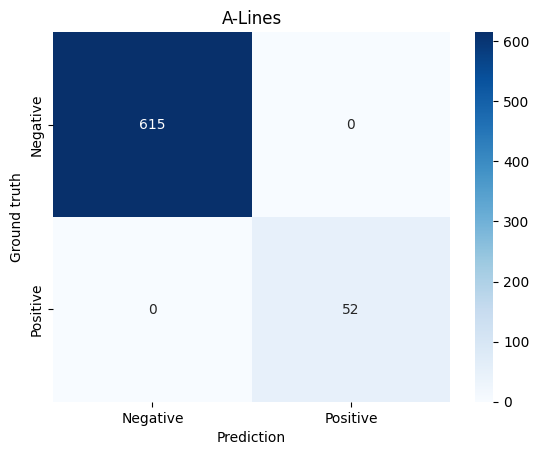

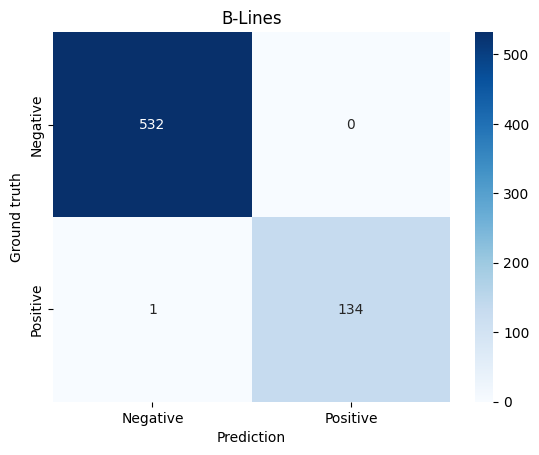

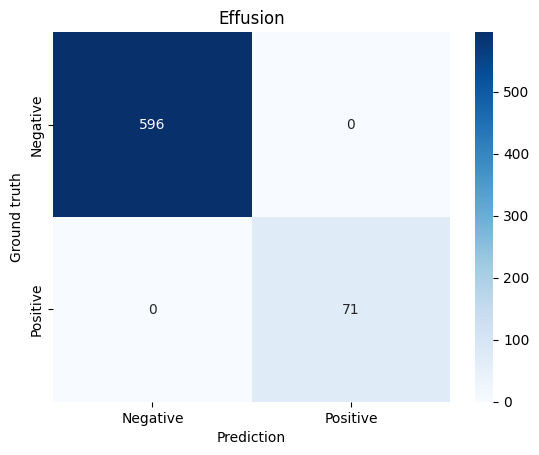

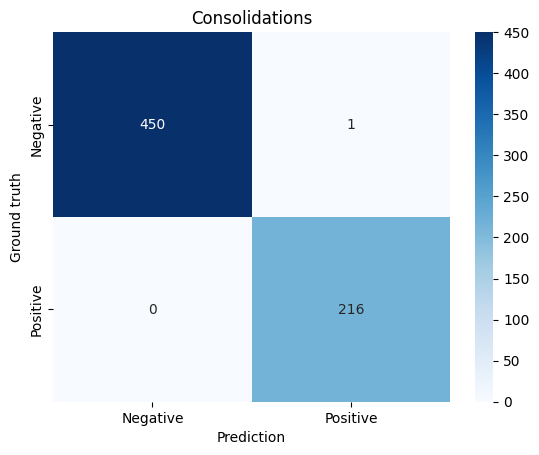

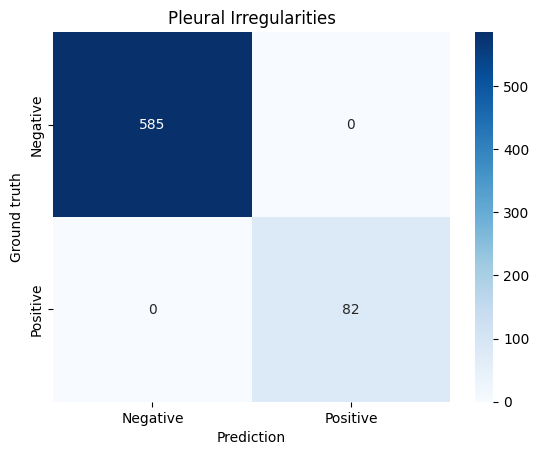

In [23]:
# Plot confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
preds = model01.predict(X_test)
preds = np.array(preds> 0.5) #limiar
preds


#
plot_results(y_test, preds)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
21/21 [==============================] - 0s 6ms/step


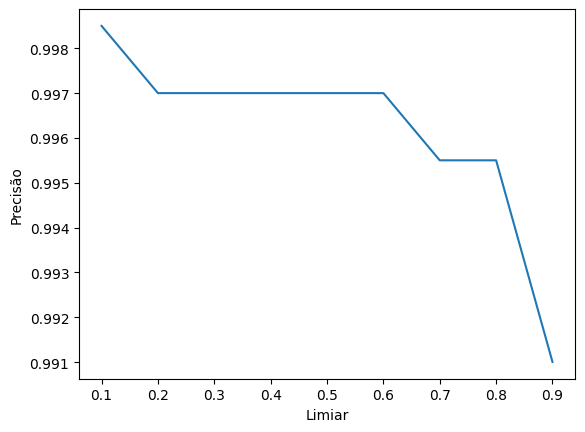

In [33]:
# plot treshold 1
import numpy as np
import matplotlib.pyplot as plt

# Calcular as previsões para todos os limiares
limiares = np.linspace(0.1, 0.9, num=9)
print(limiares)
preds = model01.predict(X_test)
accuracies = []
for limiar in limiares:
    preds_bin = np.array(preds > limiar)
    accuracy = accuracy_score(y_test, preds_bin)
    accuracies.append(accuracy)

# Plotar o gráfico
plt.plot(limiares, accuracies)
plt.xlabel("Limiar")
plt.ylabel("Precisão")
plt.show()


21/21 [==============================] - 0s 6ms/step
0.1 0.9985007496251874


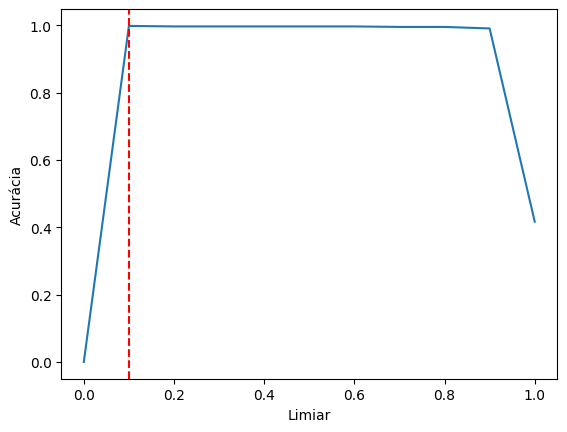

In [32]:
## plot treshold 2
from sklearn.metrics import accuracy_score

# Calcular as previsões para todos os limiares
preds = model01.predict(X_test)
best_threshold = 0
best_accuracy = 0

# Verificar o desempenho para diferentes limiares
thresholds = np.linspace(0., 1, num=11)
for threshold in thresholds:
    preds_threshold = (preds > threshold).astype(int)
    accuracy = accuracy_score(y_test, preds_threshold)
    if accuracy >= best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

print(best_threshold, best_accuracy)
# Plotar o grafico
plt.plot(thresholds, [accuracy_score(y_test, (preds > threshold).astype(int)) for threshold in thresholds])
plt.xlabel("Limiar")
plt.ylabel("Acurácia")
plt.axvline(best_threshold, color='r', linestyle='--')
plt.show()


21/21 [==============================] - 0s 6ms/step


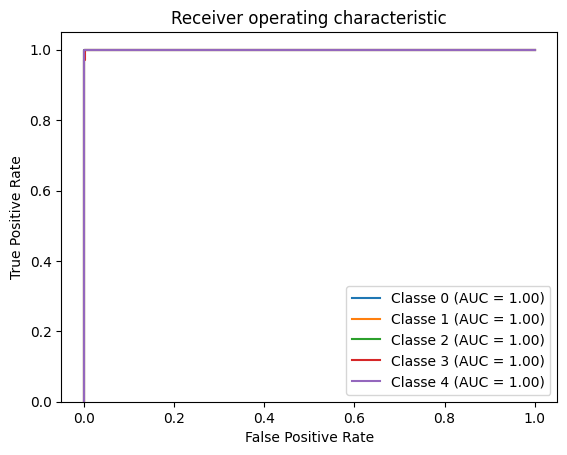

In [31]:
# ROC CURVE PLOT

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Fazer as previsões no conjunto de teste
y_pred = model01.predict(X_test)

n_classes = y_test.shape[1]

# Calcular a área sob a curva ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_test[:, i], y_pred[:, i])

# Plotar a curva ROC para cada classe
for i in range(n_classes):
#for i in range(1):
    plt.plot(fpr[i], tpr[i], label='Classe {0} (AUC = {1:0.2f})'
             ''.format(i, roc_auc[i]))

  #plt.plot([0, 1], [0, 1], 'k--')
  #plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()
